In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## THE GOAL
The idea behind this task is to extract a set of keywords, one for the right-wing party and one for the left one, from polarized submissions. These two sets will be useful to classify unseen submissions. 
This code refers to the left-wing subreddit r/Fuckthealtright.


### Getting data with pushshift API


In [0]:
import pandas as pd
import requests
import json
import pickle

In [0]:
#API REQUEST to pushishift.io/reddit/submission
#I build an URL with the relevant parameters for the search: 'after': the date from which I start to extract data, 'subreddit': the subreddit to consider
def getPushshiftData(after, sub):
    url = 'https://api.pushshift.io/reddit/search/submission?&size=1000&after='+str(after)+'&subreddit='+str(sub)
    r = requests.get(url)
    data = json.loads(r.text) #data is a dictionary containing an other dictionary 'data'
    return data['data'] #the function returns a list of 1000 dictionaries, each dictionary represents a json object (a record)

In [0]:
#Every API request returns max 1000 results I use the function ExtractDataFromTo to continue to make API request until the final date
def ExtractDataFromTo(start_date,end_date,sub):
  res=list() #list to store dictionaries (json objects) extracted
  cnt=0
  #submissions fields considered
  _key_to_store=['author', 'created_utc', 'id', 'num_comments', 'over_18', 'score', 'selftext', 'stickied', 'subreddit', 'subreddit_id', 'title']
  while int(start_date) <= end_date: #collecting data until reaching the final date
    obj=getPushshiftData(start_date,sub) 
    for elem in obj: 
        tmp=dict()
        for key in _key_to_store:
          if key not in elem.keys():
            tmp[key]='missing'
          else:
            tmp[key]=elem[key]
        res.append(tmp)
    start_date=obj[-1]['created_utc'] #at each iteration I take the unix timestamp date of the last record 
    print(start_date)
  return res

In [0]:
start=1483228800 #the beginning date in UNIX timestamp (01/01/2017)
end=1546646400 #the final date in UNIX timestamp (01/05/2019)
sub='Fuckthealtright' #the subreddit considered
res=ExtractDataFromTo(start,end,sub)

1486960843
1489773466
1492790337
1495409289
1497974544
1501283810
1502685690
1503087305
1504332494
1506455128
1508322829
1509932972
1511634279
1513203755
1514876415
1516301243
1517808485
1519058883
1520128454
1521348391
1522777680
1524234625
1525819227
1527440996
1529080452
1530243518
1531679494
1532958423
1534197260
1535718511
1537506128
1538892200
1540302013
1541086936
1542157788
1543534344
1544984884
1546794116


In [0]:
df_submission=pd.DataFrame(res)

In [0]:
#Transforming DataFrame to JSON file
df_submission.to_json('/content/gdrive/My Drive/Tesi/LDA2/Related/df_fuckthealtright.json')

In [0]:
df_LDA=pd.read_json('/content/gdrive/My Drive/Tesi/LDA2/Related/df_fuckthealtright.json')

In [0]:
len(df_LDA)

38000

### Data cleaning

In [0]:
#Creating a new DF dropping all fields not necessary for LDA
df_LDA=df_LDA.drop(columns=['author', 'created_utc', 'id', 'num_comments', 'over_18', 'score', 'stickied', 'subreddit', 'subreddit_id'],axis=1)

Counting 'selftext' distinct values in order to remove all informations useless for our goal

In [0]:
df_LDA.selftext.value_counts() 
# 31 091 records have empty selftext
# 2488 records is [deleted]
# 1769 records is [removed]
# 1326 'missing'
# 5 records is \[removed\]

In [0]:
#Replacing values of 'self_text' with no relevant meaning for LDA with white space
df_LDA['selftext']=df_LDA['selftext'].replace(['[deleted]','[removed]','missing','\[removed\]'],'')

In [0]:
#Checking if all previous work was done correctly
df_LDA.selftext.value_counts() 

Counting 'title' distinct values in order to remove all informations useless for our goal

In [0]:
df_LDA.title.value_counts() #nothing to remove

Here's How Breitbart And Milo Smuggled White Nationalism Into The Mainstream                                                                                                                                                     15
Out of boredom, I decided to engage with and try to shut down some alt-right trolls in r/CringeAnarchy. A good showcase of their shitty tactics and the baselessness of their arguments. Also, just sharing my frustration...     6
California police worked with neo-Nazis to pursue 'anti-racist' activists, documents show                                                                                                                                         6
Reddit’s The_Donald Was One Of The Biggest Havens For Russian Propaganda During 2016 Election, Analysis Finds                                                                                                                     5
Dimitrios Pagourtzis, Texas Shooting Suspect, Posted Neo-Nazi Imagery Online            

In [0]:
#Creating a new field to be processed by LDA merging title and selftext
df_LDA['text_and_title'] = df_LDA['title'] +' '+ df_LDA['selftext']

Removing emoji (there are only 229 emoji in 38k records)

In [0]:
!pip install demoji

In [0]:
df_LDA=df_LDA['text_and_title']

In [0]:
import re

In [0]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U00010000-\U0010ffff"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [0]:
for i,j in df_LDA.iteritems():
  df_LDA[i]=remove_emoji(df_LDA[i])

In [0]:
#removing other special character
for i,j in df_LDA.iteritems():
  df_LDA[i]=df_LDA[i].replace('™','')

Checking if, after dropping, some emoji still remain

In [0]:
import demoji
demoji.download_codes()

... OK (Got response in 0.10 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [0]:
cnt=0
for i,j in df_LDA.iteritems():
  emoji=demoji.findall(df_LDA[i])
  if emoji!= {} :
    cnt+=1
    print(emoji)
print(cnt)

0


In [0]:
df_LDA.to_json('/content/gdrive/My Drive/Tesi/LDA2/Related/df_FuckthealtrightLDA(38k).json') #input per LSTM

In [0]:
df_LDA = pd.read_json('/content/gdrive/My Drive/Tesi/LDA2/Related/df_FuckthealtrightLDA(38k).json', typ='series')

In [0]:
df_LDA

0        KKK Leaders Allege Producers Paid Them to Fake...
1        Happy New Year May all your dreams come true. ...
2                                           Disgusting... 
3        Extremist website insists armed march against ...
4          Picture proof that supremacist only want peace 
                               ...                        
37995    Here's a fucking video of Donald Trump saying ...
37996    DEBUNKING THE ALT-RIGHT: "Germany's Demographi...
37997                                                 Hmm 
37998    Cuckolds gonna cuck... these Trumpeters act li...
37999    Nazi Heels on the Ropes: Can Pro-Wrestling Fin...
Length: 38000, dtype: object

### Text preprocessing

In [0]:
!pip install spacy 

In [0]:
!pip install pyLDAvis

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Import NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Convert to list
submissions = df_LDA.text_and_title.values.tolist()

print(submissions[1:10])

# Remove HTTTP/HTTPS/WWW URL
submissions = [re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/|www\.)+(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', elem) for elem in submissions]

# Remove new line characters
submissions = [re.sub('\s+', ' ', elem) for elem in submissions] 

# Remove distracting single quotes
submissions=[re.sub("\'", "", elem) for elem in submissions] 

# Convert the text to lowercase
submissions=[elem.lower() for elem in submissions] 

#To avoid losing information about quoted subreddits with text preprocessing, I replace r\ with 'subred'
submissions=[re.sub('r\/','subred',elem) for elem in submissions]

print(submissions[1:10])

['Happy New Year May all your dreams come true. \nxoxo', 'Disgusting... ', 'Extremist website insists armed march against Jewish people in Montana will go ahead ', 'Picture proof that supremacist only want peace ', 'Wrecked - "Do women destroy civilizations? - A response to Black Pigeon Speaks" ', 'True Intellectuals ', 'How Alt-Right Solves Problems ', 'An invitation ', '/r/AntiTrumpAlliance - shameless plug for a new subreddit which caters to and encourages collaboration between various political factions opposing Trump. There are several fragmented subreddits that stand in opposition to Trump, his supporters, his ideas, and so on, but there is not a single consolidated "group meeting area" for all these factions to communicate. In times like this, groups that have historically been at odds find themselves teaming up to defeat a common enemy. This is the role and the function of /r/AntiTrumpAlliance. \n\nI want everyone who opposes Trump in the same room, regardless of who disagrees 

In [0]:
#Tokenize each sentence into a list of words, removing punctuations and unnecessary characters 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(submissions))

In [0]:
print(len(data_words)) 
print(data_words[0:10])

38000
[['kkk', 'leaders', 'allege', 'producers', 'paid', 'them', 'to', 'fake', 'scenes', 'in', 'canceled', 'amp', 'series', 'finally', 'realizes', 'how', 'reality', 'tv', 'works'], ['happy', 'new', 'year', 'may', 'all', 'your', 'dreams', 'come', 'true', 'xoxo'], ['disgusting'], ['extremist', 'website', 'insists', 'armed', 'march', 'against', 'jewish', 'people', 'in', 'montana', 'will', 'go', 'ahead'], ['picture', 'proof', 'that', 'supremacist', 'only', 'want', 'peace'], ['wrecked', 'do', 'women', 'destroy', 'civilizations', 'response', 'to', 'black', 'pigeon', 'speaks'], ['true', 'intellectuals'], ['how', 'alt', 'right', 'solves', 'problems'], ['an', 'invitation'], ['shameless', 'plug', 'for', 'new', 'subreddit', 'which', 'caters', 'to', 'and', 'encourages', 'collaboration', 'between', 'various', 'political', 'factions', 'opposing', 'trump', 'there', 'are', 'several', 'fragmented', 'subreddits', 'that', 'stand', 'in', 'opposition', 'to', 'trump', 'his', 'supporters', 'his', 'ideas', 'a

In [0]:
#Removing 'not' from NLTK stopwords list, I want to keep negations
for elem in stop_words:
  if elem == 'not':
    stop_words.remove(elem)

In [0]:
#Adding to the stopwords list typical reddit words
stop_words.extend(['reddit','subreddit','upvote','downvote','sub'])

In [0]:
# Define functions for stopwords and lemmatization (i keep also 'not')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ','VERB']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.text == 'not' or token.pos_ in allowed_postags])
    return texts_out

In [0]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb
data_lemmatized_one = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ','VERB'])

In [0]:
#After lemmatization I remove again the reamining stopwords
data_lemmatized=remove_stopwords(data_lemmatized_one)

In [0]:
print(data_lemmatized[:6])

[['leader', 'allege', 'producer', 'pay', 'fake', 'scene', 'cancel', 'amp', 'series', 'realize', 'reality', 'tv', 'work'], ['happy', 'new', 'year', 'may', 'dream', 'come', 'true', 'xoxo'], ['disgusting'], ['extremist', 'website', 'insist', 'armed', 'march', 'jewish', 'people', 'montana', 'go'], ['picture', 'proof', 'supremacist', 'want', 'peace'], ['wreck', 'woman', 'destroy', 'civilization', 'response', 'black', 'pigeon', 'speak']]


In [0]:
with open('/content/gdrive/My Drive/Tesi/LDA2/Related/textprocessed_FAR.pickle', 'wb') as data_unigrams:
    pickle.dump(data_lemmatized, data_unigrams, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('/content/gdrive/My Drive/Tesi/LDA2/Related/textprocessed_FAR.pickle', 'rb') as handle:
    data_lemmatized = pickle.load(handle)

## first attempt: Unigrams

### Plotting term frequencies

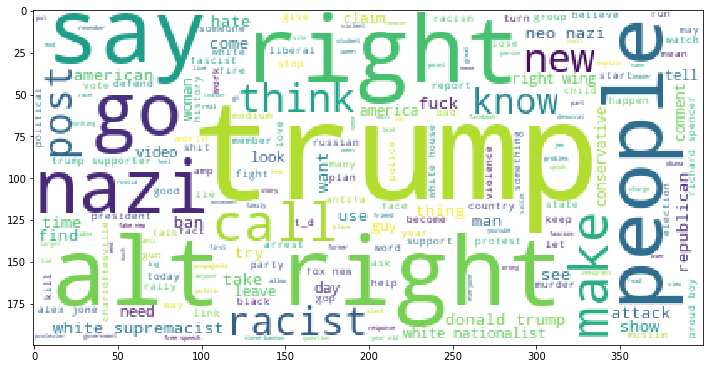

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string=''
tmp = [','.join(elem) for elem in data_lemmatized]
for elem in tmp:
    long_string+=elem+' '
# Create a WordCloud object
wordcloud = WordCloud(background_color="white")
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.savefig("/content/gdrive/My Drive/Tesi/LDA2/Graph/WordCloud_FAR_UNIGRAM.png")

In [0]:
risultato=list()
for lista in data_lemmatized:
    for elem in lista:
        risultato.append(elem)

In [0]:
import collections
counter = collections.Counter(risultato)
mostCommon=counter.most_common(20)
print(counter.most_common(20))

[('trump', 7213), ('right', 6293), ('white', 3649), ('nazi', 2959), ('not', 2764), ('alt', 2703), ('people', 2576), ('get', 2347), ('say', 2311), ('make', 1711), ('go', 1597), ('racist', 1442), ('call', 1442), ('post', 1425), ('think', 1380), ('news', 1297), ('hate', 1250), ('new', 1191), ('man', 1171), ('anti', 1088)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


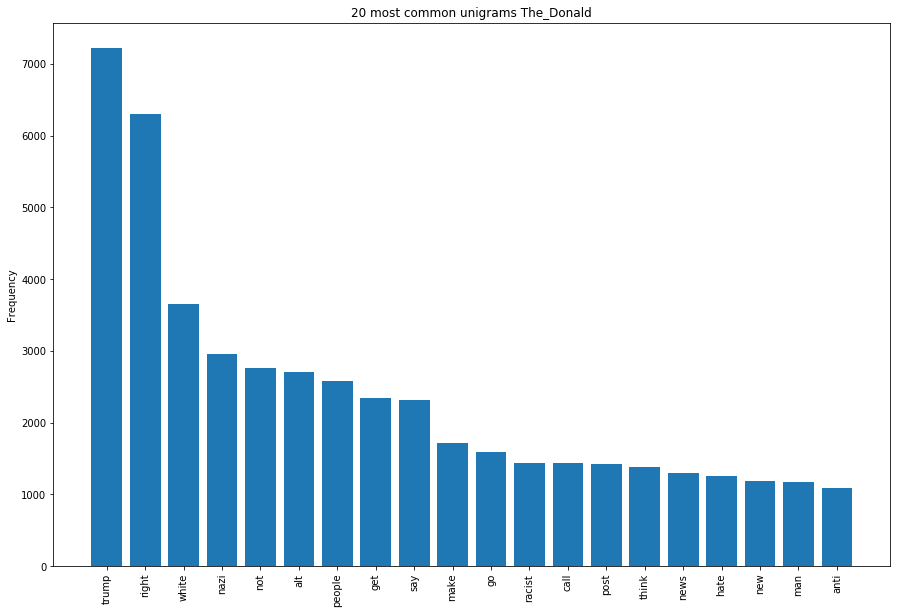

<Figure size 432x288 with 0 Axes>

In [0]:
freq=list()
names=list()
for elem in mostCommon:
  freq.append(elem[1])
  names.append(elem[0])
plt.figure(figsize=(15,10))
plt.bar([i for i in range(len(freq))],freq)
plt.xticks([i for i in range(len(freq))],names, rotation=90)
ax=plt.axes()
#ax.xaxis.grid()
plt.title('20 most common unigrams The_Donald')
plt.ylabel('Frequency')
plt.show()
plt.savefig("/content/gdrive/My Drive/Tesi/LDA2/Graph/MostcommonUNIGRAM(FAR)40k.png")

### LDA

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized) 
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0:10])
print(texts[0:10])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(19, 1), (20, 1), (21, 1)], [(22, 1), (23, 1), (24, 1), (25, 1)], [(19, 1), (26, 1), (27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(35, 1)], [(12, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1)], [(12, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)], [(52, 1), (53, 1), (54, 1)], [(55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)]]
[['fake', 'news', 'obama', 'administration', 'lie', 'origin', 'malware', 'fuel', 'russian', 'hysteria', 'fbi', 'sample', 'ukrainian', 'group', 'freely', 'available', 'several', 'version', 'date'], ['be', 'go', 'leave'], ['merkel', 'compassion', 'leftist', 'asshattery'], ['party', 'be', 'invite'], ['terror', 'turkey', 'live', 'update', 'gunfire', 'report', 'istanbul_nightclub'], ['authentic'], ['base', 'progres

In [0]:
# id2bigram view 
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('administration', 1),
  ('available', 1),
  ('date', 1),
  ('fake', 1),
  ('fbi', 1),
  ('freely', 1),
  ('fuel', 1),
  ('group', 1),
  ('hysteria', 1),
  ('lie', 1),
  ('malware', 1),
  ('news', 1),
  ('obama', 1),
  ('origin', 1),
  ('russian', 1),
  ('sample', 1),
  ('several', 1),
  ('ukrainian', 1),
  ('version', 1)]]

In [0]:
#Finding the best number of topic (k)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [0]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig("/content/gdrive/My Drive/Tesi/Graph/ChoiceofKtopic(Donald)UNIGRAMS.png")

In [0]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [0]:
# Print the Keywords in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

##second attempt: Bigrams

Forming bigrams

In [0]:
nltk.download('punkt')
from nltk import word_tokenize 
from nltk.util import ngrams

bigramTOT=list() 
for elem in data_lemmatized:
    prova=list()
    bigram = list(ngrams(elem, 2))
    for i in range(len(bigram)):
      if bigram[i][0] != bigram[i][1]: #Meaningfull bigrams must be composed by two different words
        prova.append(bigram[i][0]+'_'+bigram[i][1])
    bigramTOT.append(prova)

In [0]:
bigramTOT

In [0]:
#REMOVING EMPTY LIST (i mean submission composed by only one word, they can't be trasformed in a bigram)
cnt=0
for elem in bigramTOT:
  if elem == []:
    bigramTOT.remove(elem)

In [0]:
cnt=0
for elem in bigramTOT:
  if elem == []:
    cnt+=1
print(cnt)

0


In [0]:
with open('/content/gdrive/My Drive/Tesi/LDA2/Related/bigram_FAR.pickle', 'wb') as data:
    pickle.dump(bigramTOT, data, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('/content/gdrive/My Drive/Tesi/LDA2/Related/bigram_FAR.pickle', 'rb') as handle:
    bigramTOT = pickle.load(handle)

In [0]:
bigramTOT[0:10]

### Plotting bigrams frequencies

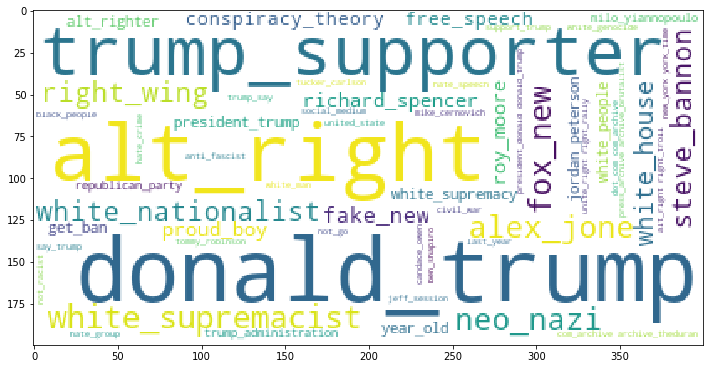

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string=''
tmp = [','.join(elem) for elem in bigramTOT]
for elem in tmp:
    long_string+=elem+' '
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.savefig("/content/gdrive/My Drive/Tesi/LDA2/Graph/WordcloudFAR.png")

In [0]:
risultato=list()
for lista in bigramTOT:
    for elem in lista:
        risultato.append(elem)

In [0]:
import collections
counter = collections.Counter(risultato)
mostCommon=counter.most_common(20)
print(counter.most_common(20))

[('alt_right', 2162), ('white_supremacist', 932), ('donald_trump', 826), ('neo_nazi', 779), ('white_nationalist', 658), ('right_wing', 654), ('trump_supporter', 523), ('alex_jone', 474), ('fox_news', 461), ('richard_spencer', 446), ('proud_boy', 343), ('white_house', 313), ('steve_bannon', 267), ('free_speech', 253), ('fake_news', 242), ('year_old', 234), ('conspiracy_theory', 202), ('roy_moore', 202), ('white_supremacy', 182), ('white_people', 159)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


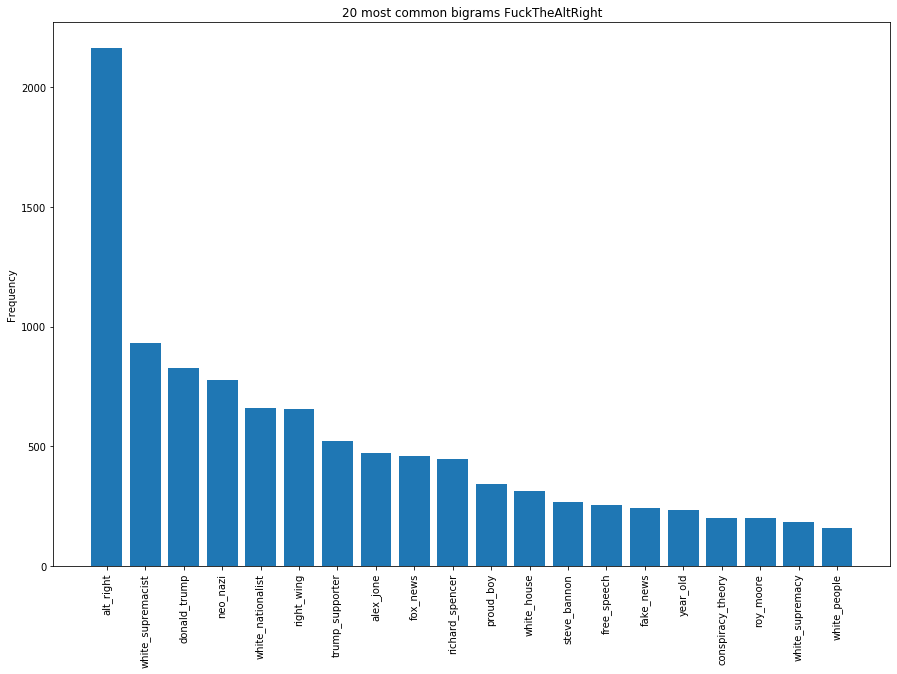

<Figure size 432x288 with 0 Axes>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

freq=list()
names=list()
for elem in mostCommon:
  freq.append(elem[1])
  names.append(elem[0])
plt.figure(figsize=(15,10))
plt.bar([i for i in range(len(freq))],freq)
plt.xticks([i for i in range(len(freq))],names, rotation=90)
ax=plt.axes()
plt.title('20 most common bigrams FuckTheAltRight')
plt.ylabel('Frequency')
plt.show()
plt.savefig("/content/gdrive/My Drive/Tesi/LDA2/Graph/MostcommonBIGRAMSFuck2.png")

###LDA bigrams

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(bigramTOT) 

# Create Corpus
texts = bigramTOT

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(id2word)
print(corpus[0:10])
print(texts[0:10])

Dictionary(219947 unique tokens: ['allege_producer', 'amp_series', 'cancel_amp', 'fake_scene', 'leader_allege']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 1), (28, 1), (29, 1), (30, 1)], [(31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(38, 1)], [(39, 1), (40, 1)], [(41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1)], [(93, 1), (94, 1), (95, 1), (96, 1)], [(

In [0]:
# id2bigram view MORE READEABLE
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('allege_producer', 1),
  ('amp_series', 1),
  ('cancel_amp', 1),
  ('fake_scene', 1),
  ('leader_allege', 1),
  ('pay_fake', 1),
  ('producer_pay', 1),
  ('reality_tv', 1),
  ('realize_reality', 1),
  ('scene_cancel', 1),
  ('series_realize', 1),
  ('tv_work', 1)]]

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, workers=3,
                                           chunksize=100,
                                           passes=10,
                                          per_word_topics=True )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bigramTOT, start=2, limit=40, step=6)

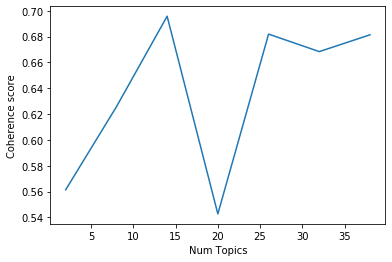

<Figure size 432x288 with 0 Axes>

In [0]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()
plt.savefig("/content/gdrive/My Drive/Tesi/LDA2/Graph/ChoiceofKtopic(FuckThealt)BIGRAMS.png")

In [0]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5614
Num Topics = 8  has Coherence Value of 0.6256
Num Topics = 14  has Coherence Value of 0.6957
Num Topics = 20  has Coherence Value of 0.5428
Num Topics = 26  has Coherence Value of 0.6819
Num Topics = 32  has Coherence Value of 0.6683
Num Topics = 38  has Coherence Value of 0.6814


In [0]:
lda_model = gensim.models.LdaMulticore(corpus, num_topics=20, id2word=id2word, workers=3,
                                           chunksize=100,
                                           passes=10,
                                          per_word_topics=True)

In [0]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"white_supremacist" + 0.004*"pittsburgh_synagogue" + '
  '0.003*"hate_group" + 0.002*"law_enforcement" + 0.002*"report_white" + '
  '0.002*"look_compare" + 0.002*"know_africa" + 0.002*"compare_country" + '
  '0.002*"africa_look" + 0.002*"synagogue_shooter"'),
 (1,
  '0.021*"white_nationalist" + 0.008*"richard_spencer" + 0.007*"fake_news" + '
  '0.005*"social_medium" + 0.004*"steve_king" + 0.003*"false_flag" + '
  '0.003*"laura_loomer" + 0.002*"anti_trump" + 0.002*"supporter_leave" + '
  '0.002*"year_prison"'),
 (2,
  '0.006*"trump_administration" + 0.004*"ocasio_cortez" + 0.003*"open_border" '
  '+ 0.002*"want_open" + 0.002*"propaganda_machine" + '
  '0.002*"alexandria_ocasio" + 0.002*"good_hope" + 0.002*"right_content" + '
  '0.002*"mass_shooting" + 0.002*"not_go"'),
 (3,
  '0.048*"alt_right" + 0.028*"right_wing" + 0.014*"alex_jone" + '
  '0.008*"candace_owen" + 0.004*"unite_right" + 0.004*"republican_party" + '
  '0.004*"white_supremacy" + 0.004*"anti_fascist" + 0.003*"

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

'''In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. 
It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample
'''
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bigramTOT, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.381299587176864

Coherence Score:  0.5605202569726735


In [0]:
lda_model.save('/content/gdrive/My Drive/Tesi/LDA2/Related/ldaFuckbigrams.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from gensim import corpora, models, similarities

In [0]:
lda = models.ldamodel.LdaModel.load('/content/gdrive/My Drive/Tesi/LDA2/Related/ldaFuckbigrams.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.130553 -0.046312       1        1  13.420126
2     -0.043924  0.013307       2        1  13.081710
6      0.020743  0.008615       3        1  12.893799
0      0.035693  0.190569       4        1  12.544976
4     -0.089299 -0.061175       5        1  12.283685
7      0.011880  0.012647       6        1  12.184516
3      0.033789 -0.007548       7        1  11.981179
1      0.161671 -0.110103       8        1  11.610005, topic_info=       Category         Freq  ...  loglift  logprob
98      Default  1128.000000  ...  30.0000  30.0000
28096   Default   485.000000  ...  29.0000  29.0000
1897    Default   473.000000  ...  28.0000  28.0000
287     Default   402.000000  ...  27.0000  27.0000
3090    Default   519.000000  ...  26.0000  26.0000
...         ...          ...  ...      ...      ...
219871   Topic8    31.444107  ...   2.1361  -7.1222
219927   Topic8    31.444107  ...   2.1361  -7.1222
219872   Topic8    31.444107  ...   2.1361  -7.1222
219928   Topic8    31.444178  ...   1.3843  -7.1222
219929   Topic8    31.444178  ...   1.3843  -7.1222

[321 rows x 6 columns], token_table=        Topic      Freq               Term
term                                      
219862      8  0.969107   active_supporter
61273       2  0.974226         ad_youtube
219837      2  0.977370      admit_villain
72714       4  0.986558       advise_trump
219922      2  0.977369        africa_look
...       ...       ...                ...
682         5  0.881004           year_old
682         8  0.115922           year_old
16909       7  0.977492        year_prison
6612        3  0.983481    youtube_channel
62720       8  0.990753  youtube_recommend

[310 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 1, 5, 8, 4, 2])

In [0]:
pyLDAvis.save_html(vis,'/content/gdrive/My Drive/Tesi/LDA2/Graph/pyLDAvis_FAR_bigrams(8topic).html')

## KEYWORD EXTRACTION

Comparison between the first set of keyword extracted by LDA with the second ones extracted after some improvements in the model

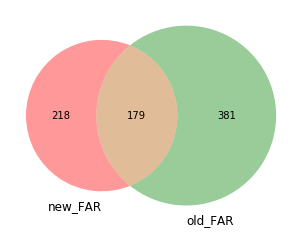

In [0]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

venn2([keyword_FAR, old_keyword_FAR], set_labels = ('new_FAR', 'old_FAR'))
plt.show()